## Project: Data Analysis and Best Practices (EDITAR)
## By Francisco Fernando Roberto Pereira
#### francisco.fernando@ufpe.br
#### franciscofernando1989@gmail.com

# 1. Problem Definition

## 1.1. Data and Work Objectives

The dataset used in this project will be the **Wind Turbine SCADA** obtained from the SCADA system (*Supervisory Control and Data Acquisition*) of a wind turbine from a wind farm in Turkey during the year 2018. Its objective is to provide time series data for the construction of predictive models to estimate the wind energy generated by the wind turbine.

The data on the attributes were acquired by the wind turbine's SCADA system in 10-minute intervals throughout the year 2018. The description of the attributes is as follows:
1. **Date/Time** - Date (in DD MM YYYY format) and time at 10-minute intervals;
2. **LV Active Power (kW)** - Power produced by the wind turbine at a given moment;
3. **Wind Speed (m/s)** - Wind speed at the hub height of the wind turbine (speed used for electricity generation);
4. **Theoretical Power Curve (kWh)** - Theoretical power values (provided by the manufacturer) that the wind turbine produces at a given wind speed;
5. **Wind Direction (°)** - Wind direction at the hub height of the wind turbine (wind turbines automatically position themselves to this direction);

For more details on this dataset, refer to: https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset

Since the objective is to predict a continuous variable (energy production) based on other variables (theoretical power, wind direction, and wind speed), this is a supervised learning problem because the model will be trained using input-output pairs. In this case, using the historical time series data of wind energy production, the model will be trained to learn the relationship between the selected attributes (features) and energy production (target).

Specifically for this MVP, the objectives are:
* Visualise the dataset in various ways to gain a general understanding of the data;
* Identify and handle *outliers*;
* Properly separate the data for the model building, training, and experimentation phases.

## 1.2. Problem Assumptions and Data Limitations

When addressing a problem of predicting wind energy production based on time series, we can consider the following assumptions:

* Relationship between wind speed and energy production: the fundamental hypothesis may be that wind energy production is significantly related to wind speed. Generally, it is expected that there is a positive relationship between wind speed and energy production.

* Effect of wind direction: wind direction can also play a role in energy production. Depending on the orientation of the wind turbines, wind direction can affect production efficiency.

* Temporal patterns: it is reasonable to assume that there are seasonal or temporal patterns in wind energy production. For example, certain times of the year may have stronger winds, leading to higher production.

The impact of other environmental variables (such as temperature, atmospheric pressure, humidity, etc.) on wind energy production will not be considered in the future model. This is a limitation of this dataset, which does not include these variables.

Additionally, there is a need to establish minimum and maximum wind speed limits. Thus, we have:

1. Cut-in speed: for a wind turbine to produce electricity, the wind must have a minimum speed, from which the wind turbines start to spin and generate electricity. This speed is known as the cut-in speed. For this analysis, the cut-in speed will be 3 m/s.

2. Cut-out speed: for safety reasons, there is a maximum wind speed limit for the equipment. For this work, the maximum speed will be 25 m/s.

These limits were established according to the operating information of the company Engie Wind Power (2023).

Source: [Wind Power | Engie](https://corporate.engie.be/en/energy/wind-power)

# 2. Data Analysis

## 2.1. Initial Setup

In [0]:
# Import libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as ms
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## 2.2. Data Loading

We will use the Pandas package (Python Data Analysis Library) to load a headerless .csv file available online.

With the dataset loaded, we will explore it a bit.

In [0]:
import pandas as pd

# Load CSV file using Pandas from a URL
url = "https://raw.githubusercontent.com/proffranciscofernando/DataScience-PUCRio-MVP2/main/windturbine_scada_dataset.csv"

# Specify the column headers
columns = ['Date/Time', 'Active Power (kW)', 'Wind Speed (m/s)', 'Theoretical Power (kWh)', 'Wind Direction (°)']

# Read the file using the specified columns
dataset = pd.read_csv(url, names=columns, skiprows=1, delimiter=',')

## 2.3. Descriptive Statistics

We will start by examining the dimensions of the dataset, its information, and some sample rows.

In [0]:
# Show the dimensions of the dataset
instances, attributes = dataset.shape
print(f'The dataset has {instances} instances and {attributes} attributes')

The dataset has 50530 instances and 5 attributes


In [0]:
# Display basic information and first few rows of the dataset
print(dataset.info())
dataset.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date/Time                50530 non-null  object 
 1   Active Power (kW)        50530 non-null  float64
 2   Wind Speed (m/s)         50530 non-null  float64
 3   Theoretical Power (kWh)  50530 non-null  float64
 4   Wind Direction (°)       50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
None


,Date/Time,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
5,01 01 2018 00:50,402.391998,5.604052,499.436385,264.578613
6,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605
7,01 01 2018 01:10,387.242188,5.306050,414.898179,257.949493
8,01 01 2018 01:20,463.651215,5.584629,493.677652,253.480698
9,01 01 2018 01:30,439.725708,5.523228,475.706783,258.723785


In [0]:
# Show the last 10 rows of the dataset
dataset.tail(10)

,Date/Time,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
50520,31 12 2018 22:20,2771.110107,10.154550,2884.512812,82.335197
50521,31 12 2018 22:30,3333.819092,12.067660,3532.081496,81.985901
50522,31 12 2018 22:40,3455.282959,12.195660,3549.150371,82.210617
50523,31 12 2018 22:50,3429.021973,12.492510,3578.567804,82.111870
50524,31 12 2018 23:00,3514.269043,12.559170,3583.288363,80.495262
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913
50529,31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620


Nothing abnormal was detected when analyzing the first 10 and last 10 rows of the dataset. For this small data sample, there are no missing values, outliers, or inconsistencies. For a more in-depth analysis, we will need to use other visualization methods.

In [0]:
# Check the data type of each attribute
dataset.dtypes

Out[10]: Date/Time                   object
Active Power (kW)          float64
Wind Speed (m/s)           float64
Theoretical Power (kWh)    float64
Wind Direction (°)         float64
dtype: object

It is always important to check the data type of the dataset attributes as conversions may be necessary. We have already done this with the info command, but we will see another way to verify the nature of each attribute and then display a statistical summary of the dataset.

In this context, we note that all attributes are of type "float64" except for "Date/Time," which is in "object" format. This means these data are being treated as text instead of dates. To perform effective temporal analyses, it is essential to convert this column to the appropriate date and time format. This will be done later in the Data Preprocessing section.

In [0]:
# Generate a statistical summary of the dataset (mean, standard deviation, minimum, maximum, and quartiles)
dataset.describe()

,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


Active Power is a measure that indicates the amount of energy being consumed or generated at a given moment. Therefore, active power generally should not be negative, as shown by the **minimum value of -2471405 kW** for this attribute. This signals that there may be other values below zero.

However, in some specific contexts, there may be cases where active power is expressed as a positive value when generated and as a negative value when consumed.

One of these cases would be when wind turbines are not producing enough energy and need to consume from the grid. There is also the situation where there may be a malfunction in the SCADA (Supervisory Control and Data Acquisition) system. Both cases will produce outlier values that need to be taken into account during data processing.

Additionally, we can make the following comments about active power:
* The **standard deviation (std) of 1312.459242 kW** indicates high variability of the attribute. This indicates that the dataset may contain high seasonality;
* The **value of 50.677890 kW corresponding to p25** indicates there is a large amount of low active power. This will be investigated later in this MVP.

## 2.4. Unimodal Visualizations

Now we will generate **frequency distribution histograms** for the dataset.

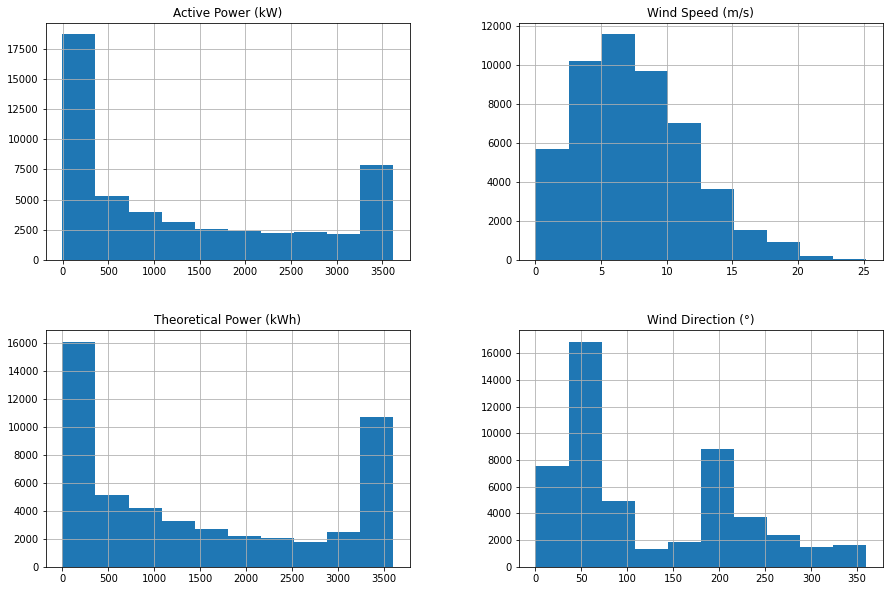

In [0]:
# Frequency histograms
dataset.hist(figsize=(15, 10))
plt.show()

From the histograms, we see that the attributes "Active Power," "Wind Direction," and "Theoretical Power" follow an approximate bimodal distribution, while "Wind Speed" follows an approximately normal distribution.

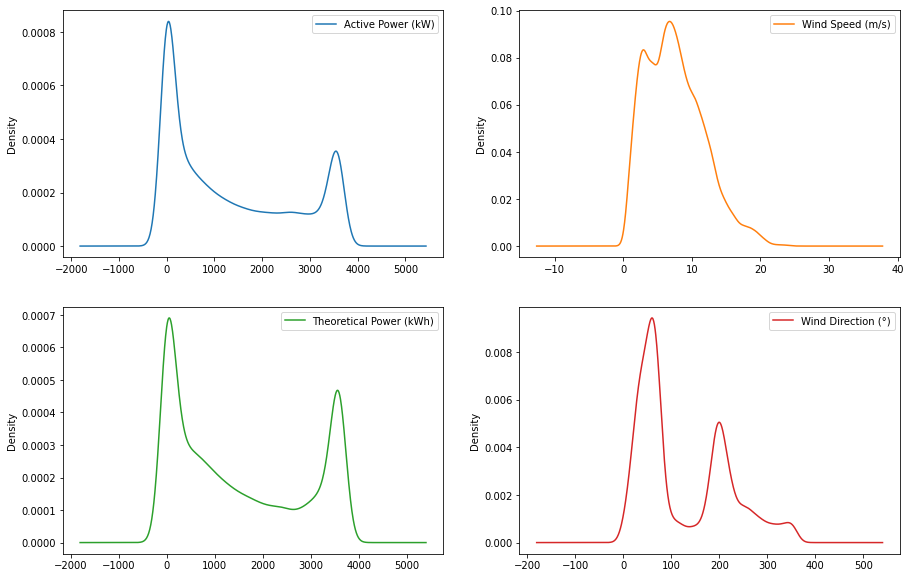

In [0]:
# Density Plot
dataset.plot(kind='density', subplots=True, layout=(2, 2), sharex=False, figsize=(15, 10))
plt.show()

The **density plot** is similar to the histogram but with a slightly different visualization. With it, it can be easier to identify the distribution of the dataset attributes. Just like we did with the histogram, we created a density plot for each attribute of the dataset. We see that many of the attributes have a skewed distribution.

Both the histogram and density plot of the "Active Power" attribute show that there is a large concentration of data close to zero. These values will be treated as outliers because they may introduce anomalous behavior in the model, representing special operating conditions that may not be representative of the system's normal behavior, as explained in the Problem Definition section.

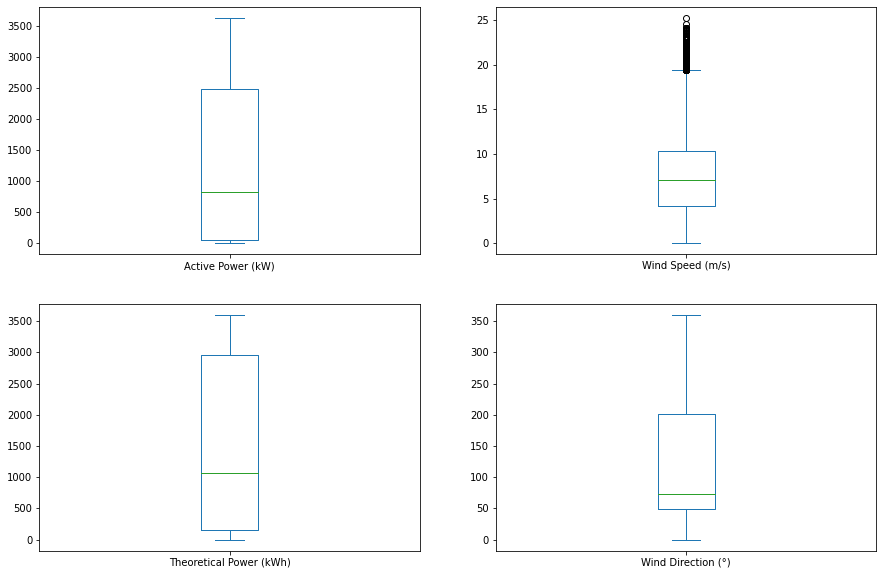

In [0]:
# Boxplot
dataset.plot(kind='box', subplots=True, layout=(2, 2), sharex=False, sharey=False, figsize=(15, 10))
plt.show()

In the boxplot, the line in the center (green) represents the median value (second quartile or p50). The line below is the first quartile (p25), and the line above is the third quartile (p75). The boxplot helps to get an idea of the dataset's dispersion and possible outliers.

Analyzing the boxplot graphs, we notice that the dispersion of the dataset attributes is quite different. In the case of "Wind Speed," there are points outside the horizontal lines (>20 m/s) that would theoretically be considered outliers. However, there are times of the year when high wind speeds are expected and not anomalous. The future model should be able to predict this context, and for this reason, some of these data must be kept. This will be done in the Outlier Treatment section.

## 2.5. Initial Data Handling

This initial dataset manipulation will be useful to enable date and time-related operations, such as extracting date components (year, month, day, etc.), performing date calculations, and other specific operations for temporal data.

In [0]:
# Make a backup copy of the original dataset
dataset_date_time = dataset.copy()

In [0]:
# Convert 'Date/Time' column to datetime
dataset_date_time['Date/Time'] = pd.to_datetime(dataset_date_time['Date/Time'], dayfirst=True)

# Create 'Month' column directly in the period format
dataset_date_time['Month'] = dataset_date_time['Date/Time'].dt.to_period('M')

# Convert 'Month' back into datetime
dataset_date_time['Month'] = dataset_date_time['Month'].dt.to_timestamp()

# Insert 'Month' column after 'Date/Time'
dataset_date_time.insert(1, 'Month', dataset_date_time.pop('Month'))

In [0]:
# Verify dataset
dataset_date_time

,Date/Time,Month,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
0,2018-01-01 00:00:00,2018-01-01,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,2018-01-01,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,2018-01-01,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,2018-01-01,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,2018-01-01,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2018-12-01,2963.980957,11.404030,3397.190793,80.502724
50526,2018-12-31 23:20:00,2018-12-01,1684.353027,7.332648,1173.055771,84.062599
50527,2018-12-31 23:30:00,2018-12-01,2201.106934,8.435358,1788.284755,84.742500
50528,2018-12-31 23:40:00,2018-12-01,2515.694092,9.421366,2418.382503,84.297913


Now we will create a monthly statistical summary to analyze means and medians. This will be used later on for comparison with the new dataset without possible missing values and outliers.

In [0]:
# Group the data by month and perform the necessary aggregation (e.g., mean, sum, etc.)
monthly_summary = dataset_date_time.groupby('Month').agg({'Active Power (kW)': ['mean', 'median'],
                                              'Wind Speed (m/s)': ['mean', 'median'],
                                              'Theoretical Power (kWh)': ['mean', 'median'],
                                              'Wind Direction (°)': ['mean', 'median']}).reset_index()

In [0]:
# Display the resulting DataFrame
monthly_summary

Month 
 Active Power (kW) 
 Wind Speed (m/s) 
 Theoretical Power (kWh) 
 Wind Direction (°) 
 
 
 
 
 mean 
 median 
 mean 
 median 
 mean 
 median 
 mean 
 median 
 
 
 
 
 0 
 2018-01-01 
 1323.157951 
 711.495605 
 8.550920 
 8.381804 
 1847.287918 
 1755.627598 
 157.829495 
 192.858200 
 
 
 1 
 2018-02-01 
 1503.355020 
 1165.232483 
 8.620697 
 8.080553 
 1712.709958 
 1576.457938 
 143.353927 
 158.485100 
 
 
 2 
 2018-03-01 
 1952.405766 
 2139.679932 
 9.734390 
 9.439749 
 2075.819877 
 2430.440890 
 190.378235 
 201.355103 
 
 
 3 
 2018-04-01 
 824.358603 
 190.471893 
 5.852096 
 4.845241 
 955.690141 
 298.870831 
 102.698848 
 70.289497 
 
 
 4 
 2018-05-01 
 836.941996 
 408.222687 
 5.859028 
 5.633562 
 960.203607 
 508.254727 
 136.501579 
 76.476257 
 
 
 5 
 2018-06-01 
 995.490376 
 571.091125 
 6.342205 
 6.162780 
 1139.291376 
 680.292725 
 130.566252 
 74.626312 
 
 
 6 
 2018-07-01 
 477.014298 
 206.341896 
 4.950335 
 4.700169 
 583.709297 
 265.613583 
 120.400853 
 63.781351 
 
 
 7 
 2018-08-01 
 1978.188795 
 2058.142090 
 9.339899 
 9.486914 
 2220.579161 
 2453.232897 
 52.473360 
 55.030590 
 
 
 8 
 2018-09-01 
 1429.484639 
 983.393036 
 7.583327 
 7.268433 
 1553.319599 
 1141.555301 
 98.196628 
 60.749859 
 
 
 9 
 2018-10-01 
 1408.274877 
 1152.753052 
 7.538289 
 7.520799 
 1534.185219 
 1268.692219 
 108.738023 
 64.570587 
 
 
 10 
 2018-11-01 
 1886.693868 
 1816.484497 
 9.373864 
 8.794999 
 2030.027723 
 2012.767122 
 101.102801 
 69.512318 
 
 
 11 
 2018-12-01 
 1176.785881 
 482.019714 
 7.357389 
 6.717962 
 1424.063554 
 893.924972 
 140.667803 
 143.424896

## 2.6. Multimodal Visualizations

The **correlation matrix** below graphically displays the correlation between the numerical attributes of the dataset.

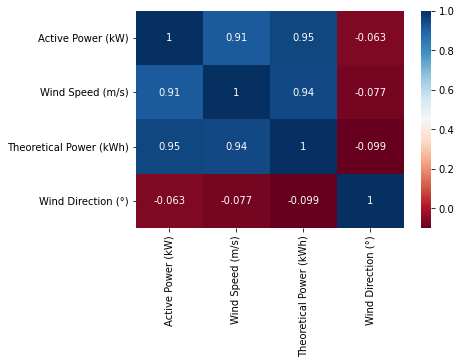

In [0]:
# Ensure only numerical columns are included in the correlation matrix
numeric_dataset = dataset_date_time.select_dtypes(include=['float', 'int'])

# Calculate the correlation matrix
corr_matrix = numeric_dataset.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdBu')
plt.show()

Visualizing the correlations between the attributes through the correlation matrix, we notice that there is a structure in the order of the attributes.

There are several ways to calculate the correlation between two variables, such as the Pearson correlation coefficient, which can be:
* Close to -1: there is a negative correlation between the variables
* Close to +1: there is a positive correlation between the variables.
* 0: there is no correlation between the variables.

In this context, all attributes are highly correlated with each other according to Pearson's correlation coefficients (all above 0.9). The only exception is wind direction, which has a very low negative correlation with the other attributes. Since the values of the correlation coefficients are very low, this correlation can be considered nonexistent.

This information about the correlation between the attributes is relevant because some algorithms, such as linear regression and logistic regression, can have performance problems if there are highly correlated attributes. It is worth consulting the algorithm documentation to check if any type of dataset treatment is necessary.

The scatter plot shows the relationship between two variables. We will display one for each pair of dataset attributes using Seaborn.

Out[21]: <seaborn.axisgrid.PairGrid at 0x7fdc0c0e4fd0>

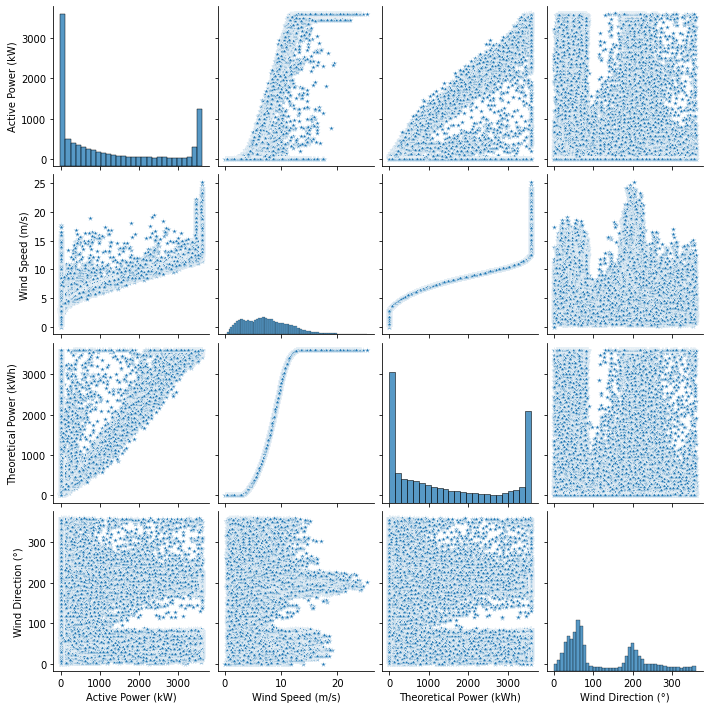

In [0]:
# Scatter Plot with Seaborn
sns.pairplot(dataset_date_time, markers='*')

In this scatter plot, the diagonal graphs provide histograms of the univariate probability distribution for each variable. These histograms show how the values of each variable are distributed.

Outside the main diagonal, each cell contains a scatter plot that represents the relationship between two variables. This helps to visualize the correlation or dependence between pairs of variables. In this context, we highlight that the attributes "Active Power" and "Theoretical Power" have a triangular distribution above and below the main diagonal, suggesting a linear relationship between the variables.

At this point, we can also visualize the power curves of the wind turbine (Active Power vs. Wind Speed and Theoretical Power vs. Wind Speed). For a more effective comparison, we will plot this curve separately below.

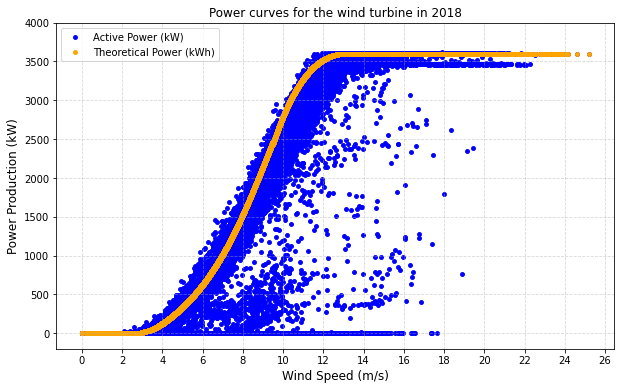

In [0]:
# Plot power curves for the wind turbine

# Prepare the figure
plt.figure(figsize=(10, 6))

# Active power
plt.scatter(dataset_date_time['Wind Speed (m/s)'], dataset_date_time['Active Power (kW)'], label='Active Power (kW)', color='blue', marker="o", s=15)

# Theoretical power
plt.scatter(dataset_date_time['Wind Speed (m/s)'], dataset_date_time['Theoretical Power (kWh)'], label='Theoretical Power (kWh)', color='orange', marker="o", s=15)

# Display legend
plt.legend()

# Label the x and y axes
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power Production (kW)', fontsize=12)
plt.title('Power curves for the wind turbine in 2018')

# Explicitly set the x-axis limits
xmin = 0  # Specify the lower limit
xmax = 26  # Specify the upper limit
x_step = 2  # Specify the step
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10)  # Set step and font size of x-axis ticks

# Set the y-axis limits and step
ymin = 0  # Specify the lower limit
ymax = 4000  # Specify the upper limit
y_step = 500  # Specify the step
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10)  # Set step and font size of y-axis ticks
plt.ylim(ymin-200, ymax)

# Add grids to the graph
plt.grid(True, linestyle='--', alpha=0.5)

# Display the graph
plt.show()

By analyzing the power curves, we can see that active power has a large number of outliers compared to theoretical power. This will be properly addressed in the section 'Handling Outliers'.

# 3. Data Preprocessing

At this stage, we could perform various data preparation operations such as handling missing values, data cleaning, transformations, and feature selection.

## 3.2. Handling Missing Values

We will now check for possible missing values.

In [0]:
# Check for nulls in the dataset
dataset_date_time.isnull().sum()

Out[23]: Date/Time                  0
Month                      0
Active Power (kW)          0
Wind Speed (m/s)           0
Theoretical Power (kWh)    0
Wind Direction (°)         0
dtype: int64

In [0]:
# Display a matrix visualization of the dataset's nullity
ms.matrix(dataset_date_time)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-586685258456608>:2
      1 # Display a matrix visualization of the dataset's nullity
----> 2 ms.matrix(dataset_date_time)

NameError: name 'ms' is not defined

We can see from the matrix and the nulls that the dataset does not have apparent missing values.

## 3.3. Handling Outliers

The three sources of outlier values considered in this project are as follows:

**1. Negative or near-zero active power values:**

 * Description: power values tend to zero when wind speed is above the cut-in speed and below the cut-out speed.

 * Possible causes: wind turbine maintenance and wind limitation.

**2. Values far from the theoretical power curve:**

 * Description: active power values are significantly far from the expected values as represented by the theoretical power curve but are not zero.

 * Possible causes: wind limitation, dirt on the blades, insects or ice, pitch control malfunction, among other factors.

**3. Values that exceed the physical limitation of the equipment:**

 * Description: wind power reaches values that exceed the physical limitation of the wind turbine.

 * Possible causes: extreme operational conditions.

These three types of outlier values are analyzed to understand the characteristics that can introduce errors in the power curve modeling. Therefore, it is essential to identify and remove these outliers from the raw data before using them to train future models.

In [0]:
# Create a backup copy of the dataset before manipulations
dataset_with_outliers = dataset_date_time.copy()

We will now divide the dataset into subsets based on the values of 'Active Power (kW)'. Then, we will remove the outliers in each subset and concatenate the treated subsets to create a new dataset without outliers. This process will be performed dynamically, adjusting the outlier removal criteria based on the specific intervals of 'Active Power (kW)' values.

In [0]:
# Function to remove outliers
def remove_outliers(df, column, min_percentile, max_percentile):
    """
    This function removes outliers from a specific column of the dataset
    using minimum and maximum percentiles.
    """
    # Calculate the quartiles for the minimum and maximum percentiles
    q_low = df[column].quantile(min_percentile)
    q_high = df[column].quantile(max_percentile)

    # Filter the DataFrame, keeping only the values within the quartile-defined range
    return df[(df[column] < q_high) & (df[column] > q_low)]

In [0]:
# Function to create data subsets
def create_data_subsets(data, step=50, upper_limit=3400):
    """
    This function divides the dataset into subsets based on the values of
    the 'Active Power (kW)' column. Each subset covers a specific range
    (defined by the step) and stores the subset in a dictionary. Each subset
    is represented by a lower limit, and the last subset includes values
    greater than or equal to 3300.
    """
    subsets = {}
    for lower_limit in range(20, upper_limit, step):
        upper_limit_current = lower_limit + step
        # Condition to create the subset based on the limits
        condition = (data['Active Power (kW)'] >= lower_limit) & (data['Active Power (kW)'] < upper_limit_current)
        subsets[lower_limit] = data[condition]

    # Add the last subset for values >= 3300
    subsets[upper_limit] = data[data['Active Power (kW)'] >= 3300]

    return subsets

In [0]:
# Create data subsets
data_subsets = create_data_subsets(dataset_with_outliers)

# Remove outliers for each data subset
for lower_limit, df in data_subsets.items():
    if lower_limit <= 3:
        F = 0.95
    elif 3 < lower_limit <= 10:
        F = 0.90
    elif 10 < lower_limit <= 20:
        F = 0.92
    elif 20 < lower_limit < 30:
        F = 0.96
    else:
        F = 0.985

    data_subsets[lower_limit] = remove_outliers(df, 'Wind Speed (m/s)', 0.0001, F)

# Concatenate the data subsets into a single dataset
filtered_dataset = pd.concat(data_subsets.values(), ignore_index=True)

The above code snippet performs the outlier removal procedure. The values of '0.0001' and 'F' were adjusted until the power curve plotted below showed less dispersion in the generated power (active) values relative to the expected values (theoretical power).

In [0]:
# Show the dimensions of the filtered dataset without outliers
instances, attributes = filtered_dataset.shape
print(f'The filtered dataset without outliers has {instances} instances and {attributes} attributes')

The original dataset (with outliers) had 50530 instances. Let's plot the new power curves to better analyze the effect of this manipulation.

In [0]:
# Plot power curves for the wind turbine

# Prepare the figure
plt.figure(figsize=(10, 6))

# Active power
plt.scatter(filtered_dataset['Wind Speed (m/s)'], filtered_dataset['Active Power (kW)'],
            label='Active Power (kW)', color='blue', marker="o", s=15)

# Theoretical power
plt.scatter(filtered_dataset['Wind Speed (m/s)'], filtered_dataset['Theoretical Power (kWh)'],
            label='Theoretical Power (kWh)', color='orange', marker="o", s=15)

# Display legend
plt.legend()

# Label the x and y axes
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power Production (kW)', fontsize=12)
plt.title('Power curves without outliers')

# Explicitly set the x-axis limits
xmin = 0  # Specify the lower limit
xmax = 26  # Specify the upper limit
x_step = 2  # Specify the step
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10)  # Set step and font size of x-axis ticks

# Set the y-axis limits and step
ymin = 0  # Specify the lower limit
ymax = 4000  # Specify the upper limit
y_step = 500  # Specify the step
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10)  # Set step and font size of y-axis ticks
plt.ylim(ymin-200, ymax)

# Add grids to the graph
plt.grid(True, linestyle='--', alpha=0.5)

# Display the graph
plt.show()

From this power curve without outliers, we can see that the active power (generated) values that were not filtered in the dataset manipulation are much closer to the theoretical power values.

## 3.4. Influence of Outlier Removal on Data

To analyze the new data distribution after outlier removal, we will plot overlapping frequency distribution histograms.

In [0]:
# Configure figure size
plt.figure(figsize=(10, 6))

# Plot histogram for dataset with outliers
plt.hist(dataset_date_time['Active Power (kW)'], bins=30, color='red', alpha=1, label='Data with outliers', edgecolor='black')

# Plot histogram for dataset without outliers
plt.hist(filtered_dataset['Active Power (kW)'], bins=30, color='#fc0', alpha=0.7, label='Data without outliers', edgecolor='black')

# Add labels and title
plt.xlabel('Active Power (kW)', fontsize=14)
plt.ylabel('Frequency Distribution', fontsize=14)
plt.title('Frequency Histogram for Datasets with and without Outliers', fontsize=14)
plt.legend()

# Add grids
plt.grid(True, linestyle='--', alpha=0.7)

# Display the histogram
plt.show()

The orange region of the graph signals the intersection between the histograms of the datasets with outliers (red bar) and without outliers (yellow bar). We see that there is a considerable reduction in the frequency of low-value outliers as these were removed from the dataset, making the data less dispersed.

Now we will create a statistical summary for the filtered dataset to understand the impact of this manipulation on the statistical data. For this, we need to group the monthly data for the new dataset.

In [0]:
# Group data by month and perform necessary aggregation (e.g., mean, sum, etc.)
monthly_summary_no_outliers = filtered_dataset.groupby('Month').agg({'Active Power (kW)': ['mean', 'median'],
                                              'Wind Speed (m/s)': ['mean', 'median'],
                                              'Theoretical Power (kWh)': ['mean', 'median'],
                                              'Wind Direction (°)': ['mean', 'median']}).reset_index()

# Display the resulting DataFrame
monthly_summary_no_outliers

Now we will plot line graphs respectively for the monthly means and medians for the dataset before and after outlier filtering.

In [0]:
# Plot line graph using seaborn for the monthly means of the wind turbine's active power in 2018
# Comparison between the original dataset and the dataset without outliers
plt.figure(figsize=(10, 6))

# Mean line in the original dataset
sns.lineplot(data=monthly_summary, x='Month', y=('Active Power (kW)', 'mean'), label='Mean with outliers', color='red', marker="o", linewidth=2, markersize=10)

# Mean line in the dataset without outliers
sns.lineplot(data=monthly_summary_no_outliers, x='Month', y=('Active Power (kW)', 'mean'), label='Mean without outliers', color='blue', marker="o", markeredgecolor='blue', markerfacecolor='white', linewidth=2, markersize=10)

# Label the x and y axes
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Monthly means of active power for different datasets')

# Explicitly set the x-axis limits
xmin = monthly_summary['Month'].min() - pd.to_timedelta('15 days')  # Subtract 15 days from the minimum
xmax = monthly_summary['Month'].max() + pd.to_timedelta('15 days')  # Add 15 days to the maximum
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10)  # Set font size of x-axis ticks

# Set the y-axis limits and step
ymin = 400  # Specify the lower limit
ymax = 2500  # Specify the upper limit
y_step = 200  # Specify the step
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10)  # Set step and font size of y-axis ticks
plt.ylim(ymin, ymax)

# Adjust the format of the x-axis to display the names for each month of the year
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Add grids to the graph
plt.grid(True, linestyle='--', alpha=0.7)

# Display the graph
plt.show()

In [0]:
# Plot line graph using seaborn for the monthly medians of the wind turbine's active power in 2018
# Comparison between the original dataset and the dataset without outliers
plt.figure(figsize=(10, 6))

# Median line in the original dataset
sns.lineplot(data=monthly_summary, x='Month', y=('Active Power (kW)', 'median'), label='Median with outliers', color='orange', marker="o", linewidth=3, markersize=11)

# Median line in the dataset without outliers
sns.lineplot(data=monthly_summary_no_outliers, x='Month', y=('Active Power (kW)', 'median'), label='Median without outliers', color='black', marker="o", markeredgecolor='black', markerfacecolor='white', linewidth=2, markersize=10)

# Label the x and y axes
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Monthly medians of active power for different datasets')

# Explicitly set the x-axis limits
xmin = monthly_summary['Month'].min() - pd.to_timedelta('15 days')  # Subtract 15 days from the minimum
xmax = monthly_summary['Month'].max() + pd.to_timedelta('15 days')  # Add 15 days to the maximum
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10)  # Set font size of x-axis ticks

# Set the y-axis limits and step
ymin = 0  # Specify the lower limit
ymax = 3200  # Specify the upper limit
y_step = 200  # Specify the step
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10)  # Set step and font size of y-axis ticks
plt.ylim(ymin, ymax)

# Adjust the format of the x-axis to display the names for each month of the year
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Add grids to the graph
plt.grid(True, linestyle='--', alpha=0.7)

# Display the graph
plt.show()

According to these graphs, we can note that both variables increased in all months for the dataset without outliers. This indicates that there was a reasonably uniform distribution of outliers throughout the year.

The monthly means post-outlier removal maintained a similar pattern to the untreated data throughout the year. For the medians, the only exception was January, suggesting a higher quantity of outliers that month.

In the month-by-month comparison before and after outlier treatment, January and December showed the greatest differences for both means and medians. This indicates that these months have more outliers than others, likely related to specific meteorological conditions during that time of year.

To have a global view of the influence of outlier removal on other statistical measures, we will produce 2 new datasets before and after the manipulation with the following data:

* Mean
* Standard deviation
* 25th percentile
* 50th percentile (median)
* 75th percentile

Let's create datasets before and after removing outliers, respectively, with the summary of the main statistical measures.

In [0]:
# Gather statistical data before outlier treatment
statistics = {
    'mean': dataset_date_time['Active Power (kW)'].mean(),
    'std': dataset_date_time['Active Power (kW)'].std(),
    '25th percentile': dataset_date_time['Active Power (kW)'].quantile(0.25),
    'median': dataset_date_time['Active Power (kW)'].median(),
    '75th percentile': dataset_date_time['Active Power (kW)'].quantile(0.75)
}

# Create DataFrame
statistical_summary = pd.DataFrame(statistics, index=['Active Power (kW)'])

# Transpose the DataFrame to make the statistics columns
statistical_summary = statistical_summary.T

In [0]:
# Gather statistical data without outliers
statistics = {
    'mean': filtered_dataset['Active Power (kW)'].mean(),
    'std': filtered_dataset['Active Power (kW)'].std(),
    '25th percentile': filtered_dataset['Active Power (kW)'].quantile(0.25),
    'median': filtered_dataset['Active Power (kW)'].median(),
    '75th percentile': filtered_dataset['Active Power (kW)'].quantile(0.75)
}

# Create DataFrame
statistical_summary_no_outliers = pd.DataFrame(statistics, index=['Active Power (kW)'])

# Transpose the DataFrame to make the statistics columns
statistical_summary_no_outliers = statistical_summary_no_outliers.T

Now let's create a bar chart to compare all statistical measures in the same figure.

In [0]:
# Configure bars
plt.figure(figsize=(10, 6))
barWidth = 0.35
r1 = range(len(statistical_summary))
r2 = [x + barWidth for x in r1]

# Create the bar chart
plt.bar(r1, statistical_summary['Active Power (kW)'], color='red', width=barWidth, label='with outliers')
plt.bar(r2, statistical_summary_no_outliers['Active Power (kW)'], color='blue', width=barWidth, label='without outliers')

# Add labels to bars
plt.xlabel('Statistics', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Comparison of statistics with and without outliers', fontsize=14)
plt.xticks([r + barWidth/2 for r in range(len(statistical_summary))], list(statistical_summary_no_outliers.index), fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend()

# Add grids to the chart
plt.grid(True, linestyle='--', alpha=0.1)

# Add max values above bars in the dataset with outliers
for i, value in enumerate(statistical_summary['Active Power (kW)']):
    plt.text(r1[i], value + 10, str(round(value, 1)), ha='center', va='bottom', fontsize=10, color='black')

# Add max values above bars in the dataset without outliers
for i, value in enumerate(statistical_summary_no_outliers['Active Power (kW)']):
    plt.text(r2[i], value + 10, str(round(value, 1)), ha='center', va='bottom', fontsize=10, color='black')

# Display the chart
plt.show()

According to the bar chart, after the removal of outliers, there was an increase in the mean and all percentiles. This was expected since:

* There is a large number of outliers with very low values (as shown in the histogram). Thus, once these values are removed, the distribution of the remaining data is now considered from higher values, causing an increase in percentiles. Moreover, the mean also increases as it is more sensitive to extreme values.

* There was a reduction in data variability, evidenced by the reduction in the standard deviation.

Despite the slight reduction in the standard deviation after removing the outliers, this value is still very high. This confirms that energy production in this location is seasonal, probably due to high variability in wind conditions throughout the year.

## 4. Conclusion

In this MVP, it was possible to verify that:

* The data contained in the Wind Power SCADA dataset generally presented good quality.

* No missing values were detected during the data analysis.

* The outliers were handled with no relevant loss of information after the procedure.